In [1]:
import cmocean.cm as cm
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from salishsea_tools import viz_tools
from datetime import datetime


In [2]:
U = xr.open_dataset('/ocean/vvalenzuela/MOAD/EOSC_510/test_extractions/SalishSeaCast_hourly_U_extracted_20230101_20230114.nc')
V = xr.open_dataset('/ocean/vvalenzuela/MOAD/EOSC_510/test_extractions/SalishSeaCast_hourly_V_exctracted_20230101_20230114.nc')
W = xr.open_dataset('/ocean/vvalenzuela/MOAD/EOSC_510/test_extractions/SalishSeaCast_hourly_W_extracted_20230101_20230114.nc')
bathy = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc')
mesh = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/mesh_mask202108.nc')
time=U.time


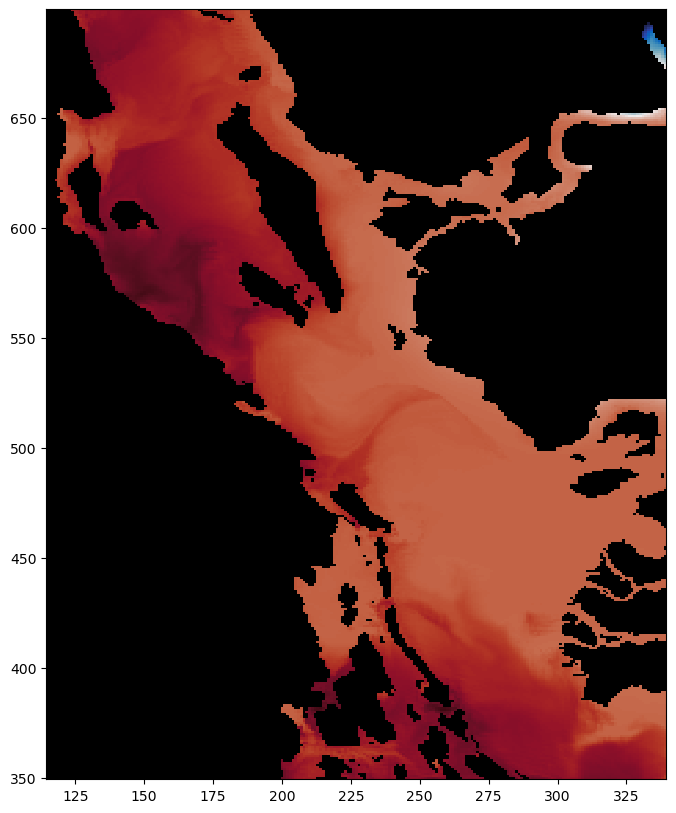

In [3]:
# SAME LIMITS USED FOR THE RESHAPR EXTRACTION
imin = 350
imax = 700
jmin = 115
jmax = 340
#
land = np.array(np.isnan(bathy.Bathymetry).to_numpy(), dtype='float')
land[land == 0] = np.nan
land=land[imin:imax, jmin:jmax]
#
fig1, ax1 = plt.subplots(figsize=(8, 10))
cmap = cm.balance
cmap.set_bad('black')
tmask = 1 - mesh.tmask[0][:,imin:imax, jmin:jmax]
Uarray = np.ma.array(U.vozocrtx[0, 0, :350,:])
Varray = np.ma.array(V.vomecrty[0, 0, :350,:])
Warray = np.ma.array(W.vovecrtz[0, 0, :350,:])

uvel = np.ma.masked_array(Uarray, mask=tmask[0])
vvel = np.ma.masked_array(Varray, mask=tmask[0])
wvel = np.ma.masked_array(Warray, mask=tmask[0])
plt.pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax),wvel,cmap=cmap)


In [4]:
# (time, depth, gridY,gridX)
# Put U, V & W in a single matrix and perform PCA
p = 0 # SURFACE
U_vel=U.vozocrtx[:,p,:350, :].to_numpy()# 336
V_vel=V.vomecrty[:,p,:350, :].to_numpy()
W_vel=W.vovecrtz[:,p,:350, :].to_numpy()
# each matrix is reshaped as TIME, lenn(gridX*gridY)
VEL=np.array([U_vel.reshape(len(U_vel[:,0,0]),len(U_vel[0,:,0])*len(U_vel[0,0,:])), V_vel.reshape(len(V_vel[:,0,0]),len(V_vel[0,:,0])*len(V_vel[0,0,:])), W_vel.reshape(len(W_vel[:,0,0]),len(W_vel[0,:,0])*len(W_vel[0,0,:]))]) # VEL[0] --> U_vel,  VEL[1] --> V_vel,  VEL[2] --> W_vel

In [5]:
# A SINGLE MATRIX IS CREATED WITH THE SHAPE OF (time, length(U+V+W)
vels=np.empty([len(VEL[0,:,0]), len(VEL[0,0,:])*3])
vels[:,:len(VEL[0,0,:])]=VEL[0,:,:]
vels[:,len(VEL[0,0,:]):len(VEL[0,0,:])*2]=VEL[1,:,:]
vels[:,len(VEL[0,0,:])*2:]=VEL[2,:,:]
# Looks BETTER! :D

In [6]:
vels=np.nan_to_num(vels)# get rid of NaNs

In [7]:
Nx = U_vel.shape[1]
Ny = U_vel.shape[2]

In [8]:
pca = PCA(n_components=np.min(vels.shape))
PCs = pca.fit_transform(vels)  # calulate PCs; y.T -> we needed to transform the original matrix so that y data is inputted into PCA with len()=100 (so len(y)=12; while len(y.T)=100; len being the lenght of the array)
eigvecs = pca.components_  # calculate eigenvectors 
frac_var = pca.explained_variance_ratio_  # calculate fraction of variance explained by each mode
eigvecs.shape

(336, 236250)

Variance explained by the first 3 eigenvectors is equal to        0.5358597260798587


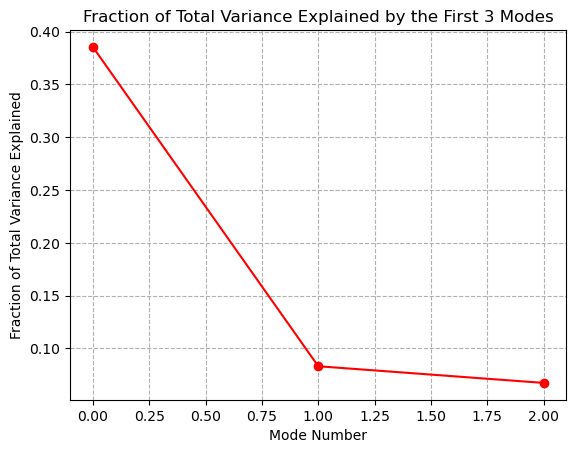

In [9]:
# plot the fraction of variance explained by each mode
plt.plot(frac_var[:3],"o-",c="r")
plt.xlabel("Mode Number")
plt.ylabel("Fraction of Total Variance Explained")
plt.title('Fraction of Total Variance Explained by the First 3 Modes')
plt.savefig('Fraction_of_Variance.png')
plt.grid(linestyle='--')
print('Variance explained by the first 3 eigenvectors is equal to        ' + str(sum(frac_var[:3])))

In [10]:
eigen_U=eigvecs[:,:Nx*Ny]
eigen_V=eigvecs[:,Nx*Ny:Nx*Ny*2]
eigen_W=eigvecs[:,Nx*Ny*2:]

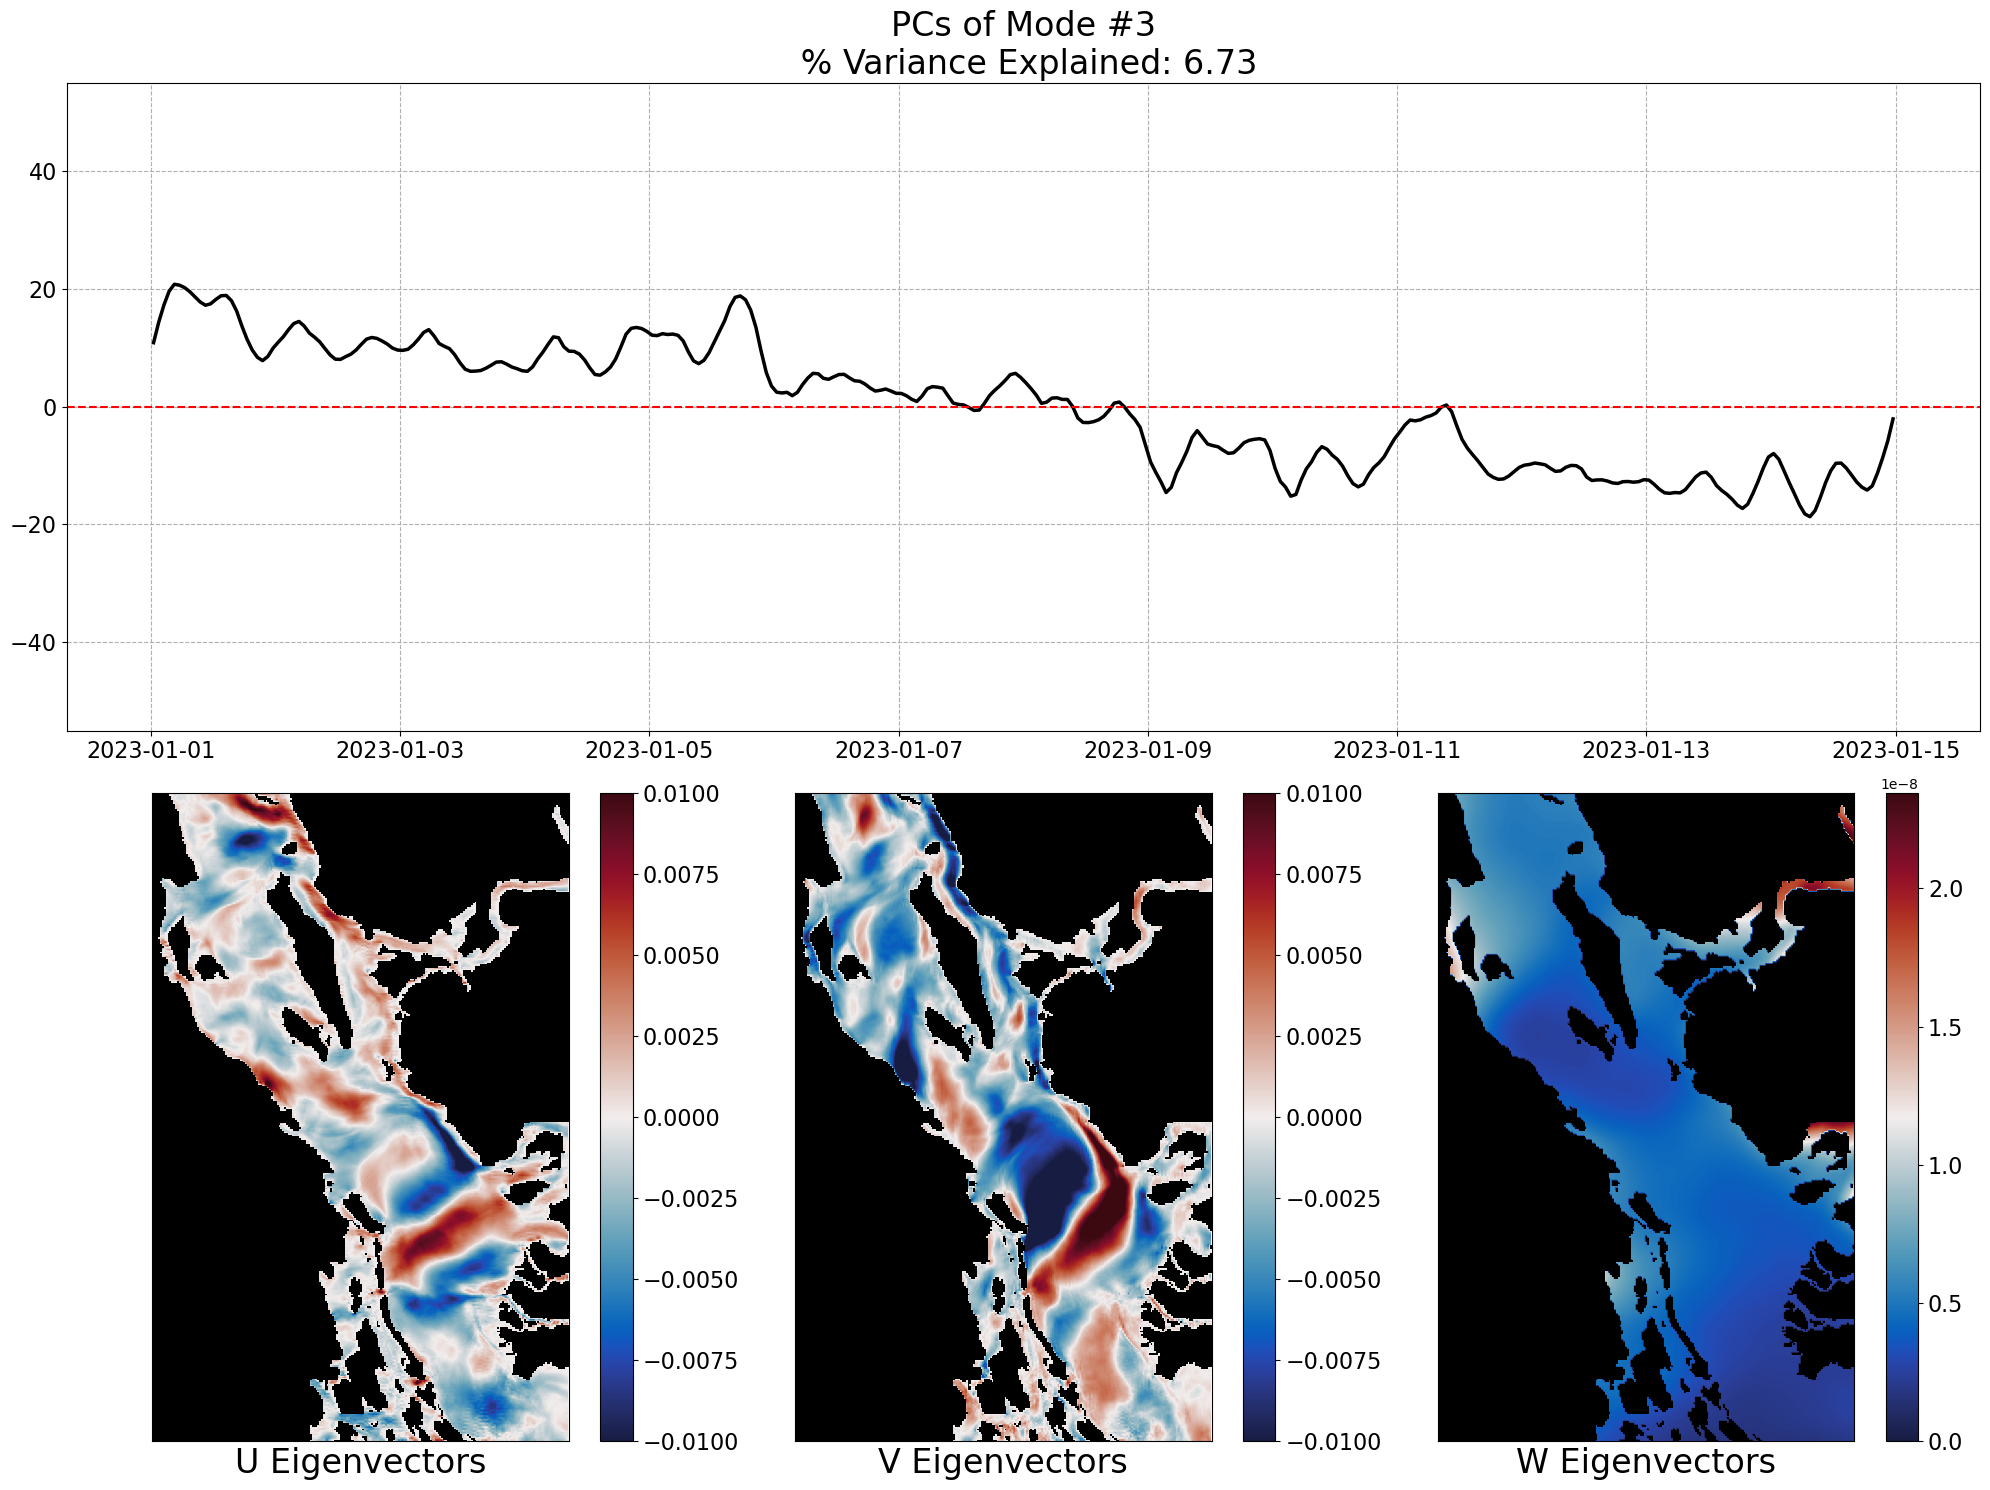

In [31]:
mode=2
cmap = cm.balance
cmap.set_bad('black')
#
fig = plt.figure(figsize=(20, 15),layout='tight')
spec = fig.add_gridspec(2, 3)
#
ax0 = fig.add_subplot(spec[1, 0])
U_plot=np.ma.masked_array(np.flipud(np.reshape(eigen_U[mode],(Nx,Ny))), mask=tmask[0])
U_cb = ax0.imshow(np.flipud(np.reshape(eigen_U[mode],(Nx,Ny))), cmap=cmap)
uc=plt.colorbar(U_cb)
uc.ax.tick_params(labelsize=16)
cb2 = ax0.pcolormesh(np.flipud(land), cmap='gist_gray')  
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
U_cb.set_clim(-0.01,0.01)
#viz_tools.set_aspect(ax0[0]);
ax0.set_xlabel('U Eigenvectors', fontsize = 24)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
#
ax1 = fig.add_subplot(spec[1, 1])
V_plot=np.ma.masked_array(np.flipud(np.reshape(eigen_V[mode],(Nx,Ny))), mask=tmask[0])
V_cb = ax1.imshow(np.flipud(np.reshape(eigen_V[mode],(Nx,Ny))), cmap=cmap)
vc=plt.colorbar(V_cb)
vc.ax.tick_params(labelsize=16)
cb2 = ax1.pcolormesh(np.flipud(land), cmap='gist_gray') 
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
V_cb.set_clim(-0.01,0.01)
#viz_tools.set_aspect(ax1[1]);
ax1.set_xlabel('V Eigenvectors', fontsize = 24)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
#
ax3 = fig.add_subplot(spec[1, 2])
W_plot=np.ma.masked_array(np.flipud(np.reshape(eigen_W[mode],(Nx,Ny))), mask=tmask[0])
W_cb = ax3.imshow(np.flipud(np.reshape(eigen_W[mode],(Nx,Ny))), cmap=cmap)
wc=plt.colorbar(W_cb)
wc.ax.tick_params(labelsize=16)
cb2 = ax3.pcolormesh(np.flipud(land), cmap='gist_gray') 
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#viz_tools.set_aspect(ax3[2]);
ax3.set_xlabel('W Eigenvectors', fontsize = 24)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
#
ax4 = fig.add_subplot(spec[0, :])
plt.plot(time,PCs[:,mode],'k', linewidth = 2.5)
plt.title('PCs of Mode #' + str(mode+1) + "\n % Variance Explained: " + str(round(100*frac_var[mode],2)), fontsize = 24)
#plt.xlabel('Time', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim([-55, 55])
plt.grid(linestyle='--')
plt.axhline(y = 0, color = 'r', linestyle = '--') 


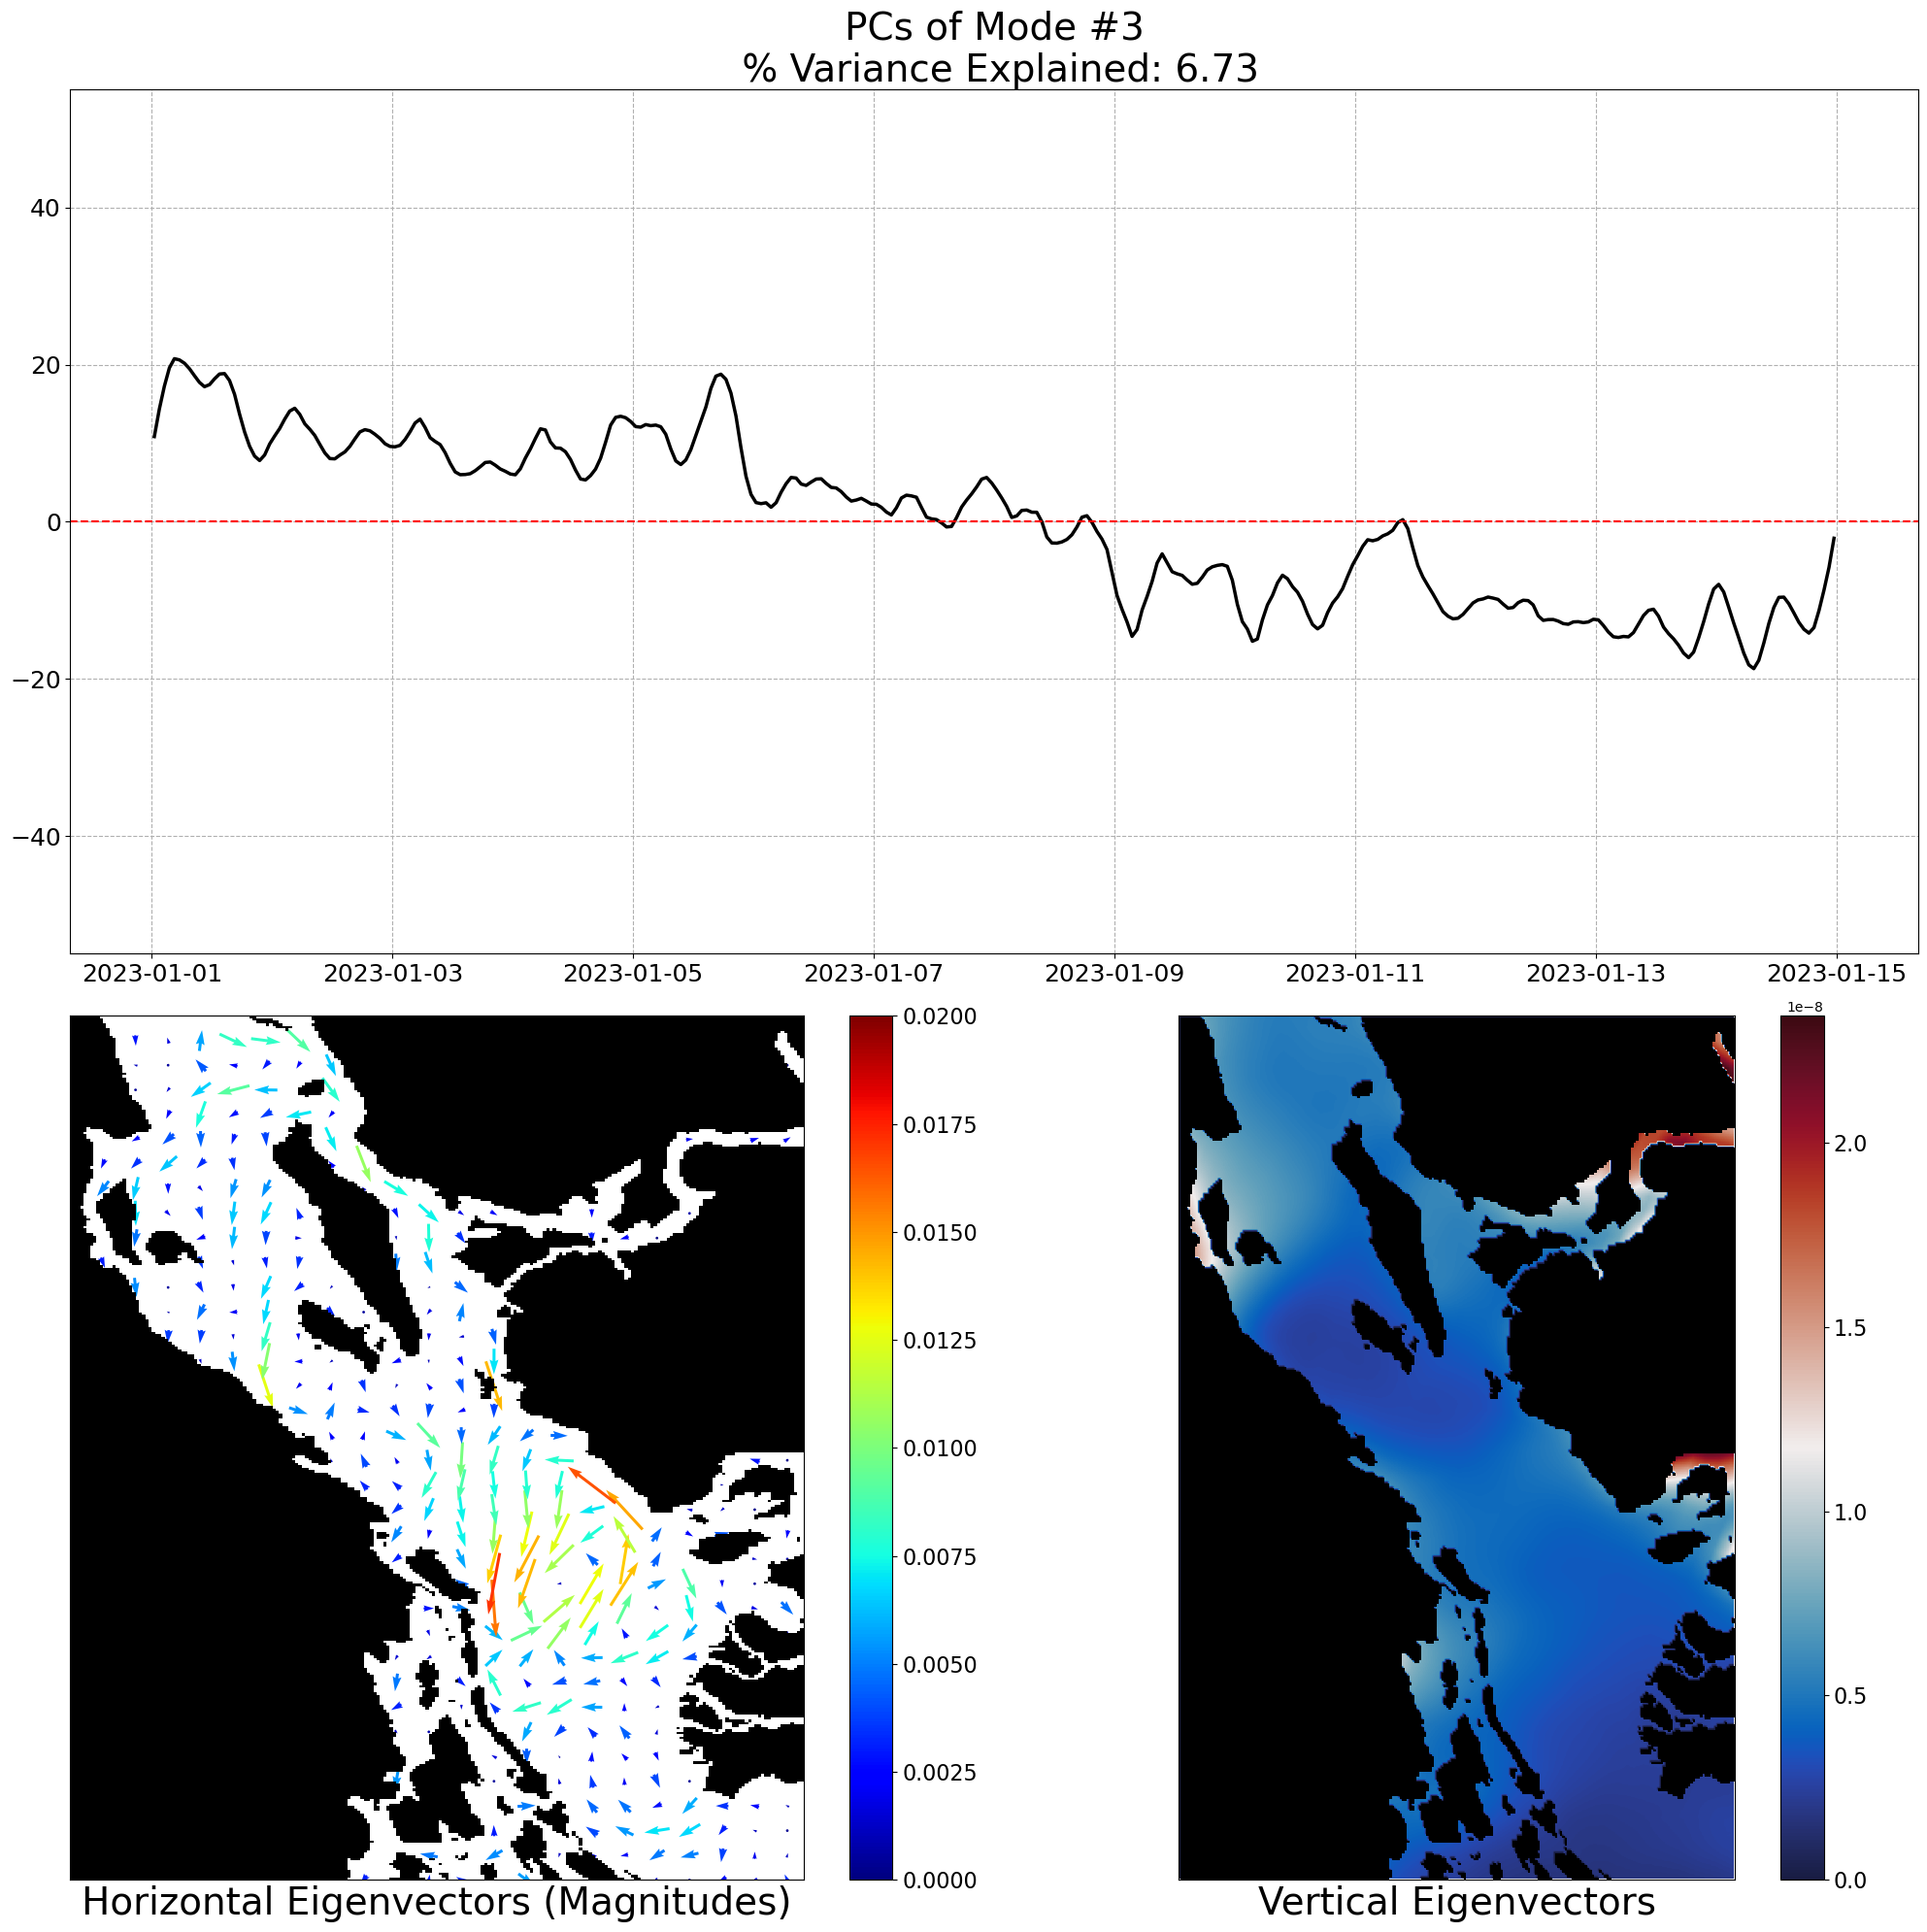

In [32]:
y_slice = np.arange(0,Nx)
x_slice = np.arange(0, Ny)
#
ap = 10
y_slice_a = y_slice[::ap]
x_slice_a = x_slice[::ap]
#
ugrid_tzyx = np.ma.masked_values(np.reshape(eigen_U[mode],(Nx,Ny)), 0)
vgrid_tzyx = np.ma.masked_values(np.reshape(eigen_V[mode],(Nx,Ny)), 0)
u_tzyx, v_tzyx = viz_tools.unstagger(ugrid_tzyx, vgrid_tzyx)
speeds=np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
#
fig = plt.figure(figsize=(20, 20),layout='tight')
spec = fig.add_gridspec(2, 2)
#
ax0 = fig.add_subplot(spec[1, 0])
UV_cb = ax0.quiver(x_slice_a[:], y_slice_a[:], u_tzyx[::ap,::ap], v_tzyx[::ap,::ap],speeds[::ap,::ap],scale=.2,pivot='mid',cmap='jet', width=0.004, )
UC=plt.colorbar(UV_cb)
UC.ax.tick_params(labelsize=16)
cb2 = ax0.pcolormesh(land, cmap='gist_gray') 
UV_cb.set_clim(0,0.02)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax0.set_xlabel('Horizontal Eigenvectors (Magnitudes)', fontsize = 28)
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
#
ax1 = fig.add_subplot(spec[1, 1])
W_plot=np.ma.masked_array(np.flipud(np.reshape(eigen_W[mode],(Nx,Ny))), mask=tmask[0])
W_cb = ax1.imshow(np.flipud(np.reshape(eigen_W[mode],(Nx,Ny))), cmap=cmap)
WC=plt.colorbar(W_cb)
WC.ax.tick_params(labelsize=16)
cb2 = ax1.pcolormesh(np.flipud(land), cmap='gist_gray') 
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
#viz_tools.set_aspect(ax1);
ax1.set_xlabel('Vertical Eigenvectors', fontsize = 28)
#
ax2 = fig.add_subplot(spec[0, :])
ax2.plot(time,PCs[:,mode],'k', linewidth = 2.5)
ax2.set_title('PCs of Mode #' + str(mode+1) + "\n % Variance Explained: " + str(round(100*frac_var[mode],2)), fontsize = 28)
ax2.grid(linestyle='--')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim([-55, 55])
plt.axhline(y = 0, color = 'r', linestyle = '--') 

plt.tight_layout()

[Text(1, 1672533000000000000, '01/01/2023'),
 Text(1, 1673137800000000000, '01/07/2023'),
 Text(1, 1673739000000000000, '01/14/2023')]

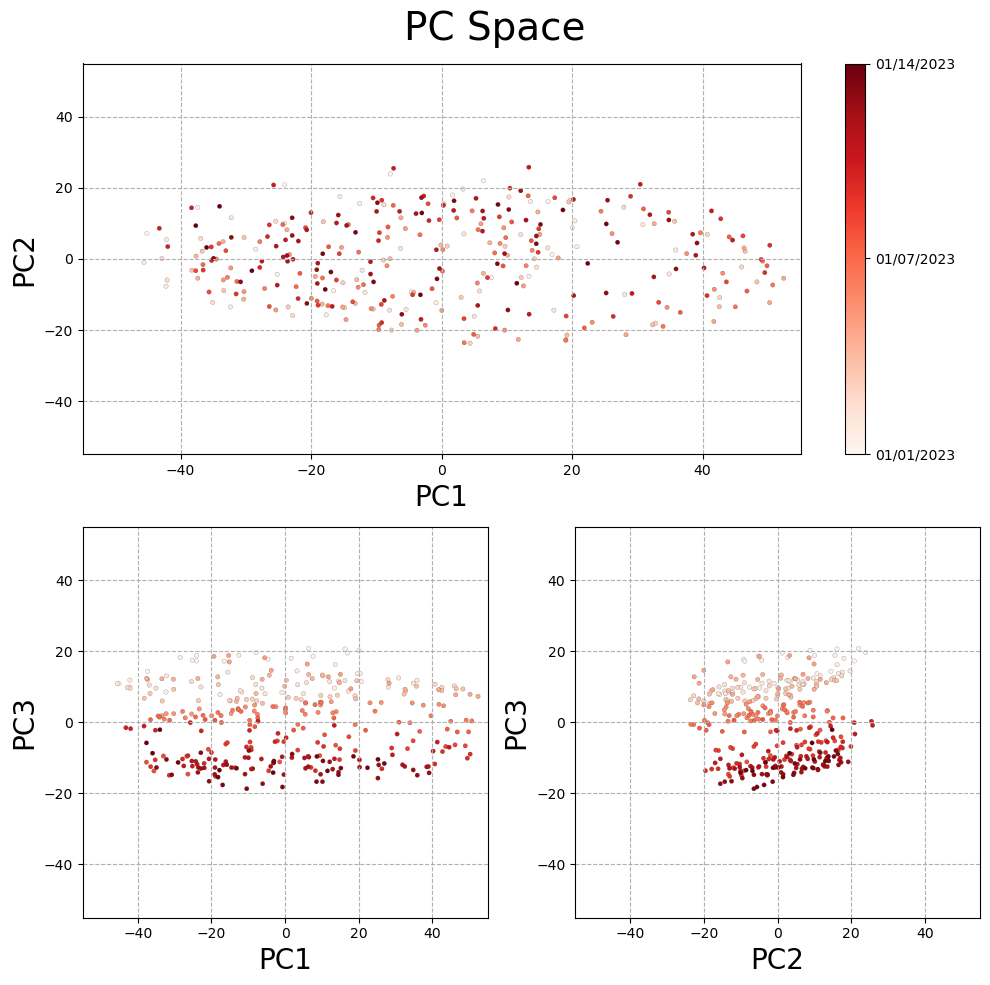

In [33]:
mm=0
fig = plt.figure(figsize=(10, 10),layout='tight')
spec = fig.add_gridspec(2, 2)
#
ax1 = fig.add_subplot(spec[0, :])
disp=ax1.scatter(PCs[:,mm],PCs[:,mm+1],s=10,alpha=1, c = time, cmap = 'Reds', edgecolor = 'k', linewidth = 0.1)
ax1.set_xlim([-55,55])
ax1.set_ylim([-55,55])
ax1.set_xlabel('PC1',fontsize=20)
ax1.set_ylabel('PC2',fontsize=20)
plt.grid(linestyle='--')
#
ax2 = fig.add_subplot(spec[1, 1])
ax2.scatter(PCs[:,mm+1],PCs[:,mm+2],s=10,alpha=1, c = time, cmap = 'Reds', edgecolor = 'k', linewidth = 0.1)
ax2.set_xlim([-55,55])
ax2.set_ylim([-55,55])
ax2.set_xlabel('PC2',fontsize=20)
ax2.set_ylabel('PC3',fontsize=20)
plt.grid(linestyle='--')
#
ax3 = fig.add_subplot(spec[1, 0])
ax3.scatter(PCs[:,mm],PCs[:,mm+2],s=10,alpha=1, c = time, cmap = 'Reds', edgecolor = 'k', linewidth = 0.1)
ax3.set_xlim([-55,55])
ax3.set_ylim([-55,55])
ax3.set_xlabel('PC1',fontsize=20)
ax3.set_ylabel('PC3',fontsize=20)
plt.grid(linestyle='--')
plt.suptitle('PC Space',fontsize=28)
#
cbar=fig.colorbar(disp, ticks=[time.item(0),time.item(168),time.item(-1)])
cbar.ax.set_yticklabels(['01/01/2023','01/07/2023','01/14/2023'])


Text(0.5, 1.0, 'PCs of the First Three Modes')

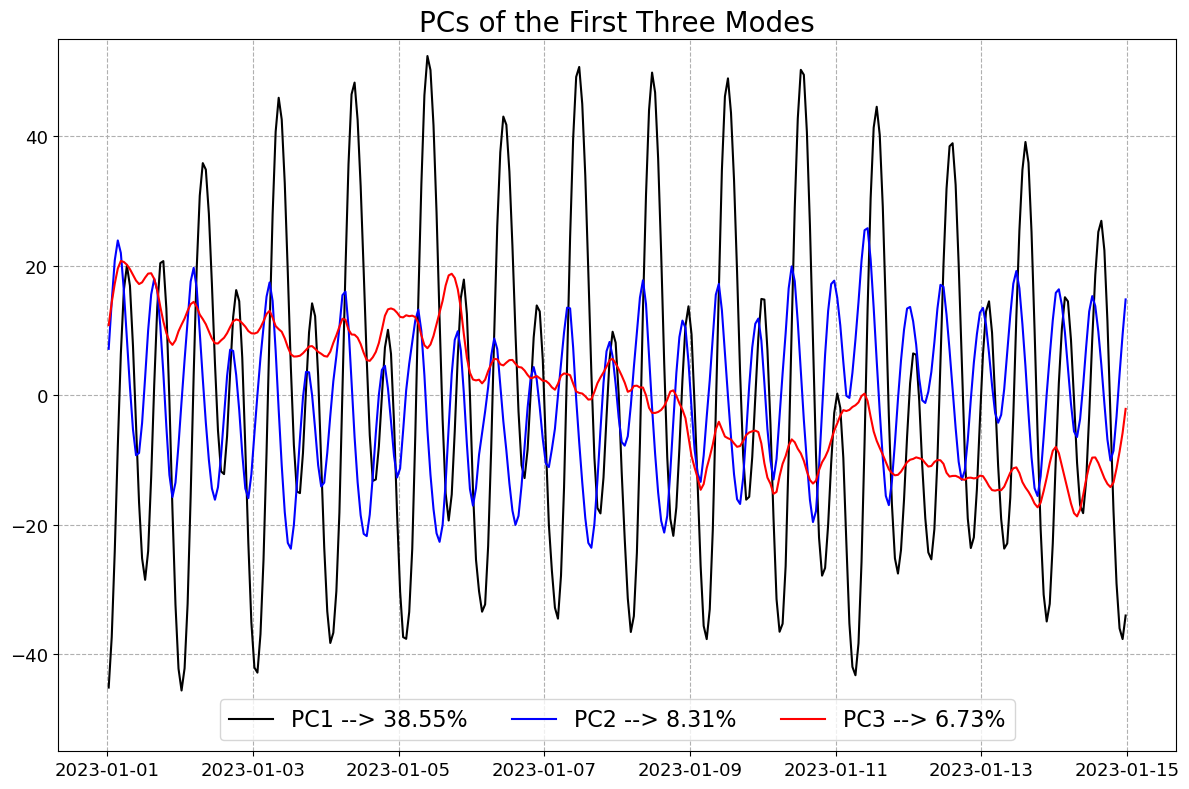

In [34]:
fig = plt.figure(figsize=(12, 8),layout='tight')
plt.plot(time,PCs[:,0],'k')
plt.plot(time,PCs[:,1],'b')
plt.plot(time,PCs[:,2],'r')
plt.legend(['PC1 --> ' + str(round(100*frac_var[0],2)) + '%','PC2 --> ' + str(round(100*frac_var[1],2)) + '%','PC3 --> ' + str(round(100*frac_var[2],2)) + '%'],ncols=3, loc='lower center',fontsize=16)
plt.grid(linestyle='--')
plt.ylim([-55, 55])
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('PCs of the First Three Modes', fontsize=20)
